In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
filepath = 'financial_goal_data.csv'
dataset = pd.read_csv(filepath)
dataset.head()

,income,expenses_listrik,expenses_transport,expenses_makanan,goal_amount,goal_duration,remaining_time,goal_achievable,current_savings
0,10000000,1000000,1000000,2500000,20000000,9,8,1,1800000
1,12000000,800000,500000,3000000,30000000,3,2,0,5700000
2,8000000,700000,600000,1500000,20000000,9,7,1,2900000
3,12000000,500000,1200000,2500000,10000000,9,8,1,3500000
4,12000000,700000,800000,1500000,25000000,12,12,1,900000


In [6]:
def create_training_data(filepath):
  #read csv file
  dataset = pd.read_csv("financial_goal_data.csv")

  # Pastikan goal_duration tidak nol
  dataset = dataset[dataset['goal_duration'] > 0]

  #add monthly_target_savings as new feature
  dataset['monthly_target_savings'] = (dataset['goal_amount'] - dataset['current_savings']) / dataset['goal_duration']

  #define feature and target
  features = dataset[['goal_amount', 'goal_duration', 'current_savings']].values
  targets = dataset['monthly_target_savings']

  return features, targets

In [7]:
#generate training data
X, y = create_training_data(filepath)
print('Features X : ', X[:5])
print('\nTargets Y : ', y[:5])
print(f'\nFeatures X shape : {X.shape}')
print(f'\nTargets Y shape : {y.shape}')

Features X :  [[20000000        9  1800000]
 [30000000        3  5700000]
 [20000000        9  2900000]
 [10000000        9  3500000]
 [25000000       12   900000]]

Targets Y :  0    2.022222e+06
1    8.100000e+06
2    1.900000e+06
3    7.222222e+05
4    2.008333e+06
Name: monthly_target_savings, dtype: float64

Features X shape : (10000, 3)

Targets Y shape : (10000,)


In [8]:
#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#normalize the features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [10]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

In [11]:
def define_and_compile_model():
  #define DNN model
  model = tf.keras.Sequential([
      #input layers with number of features
      tf.keras.layers.Input(shape=(3,)),
      #hidden layers
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=16, activation='relu'),
      #output layer
      tf.keras.layers.Dense(units=1, activation='linear') #predict monthly savings target
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.01,
      decay_steps=1000,
      decay_rate=0.9
  )
  #compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss='mse',
      metrics=['mae']
  )

  return model

In [12]:
#defining the callback
class EarlyStopCallback(tf.keras.callbacks.Callback):
  def __init__(self, monitor='mae', threshold=1.1612e-04, patience=50):
    super(EarlyStopCallback, self).__init__()
    self.monitor = monitor
    self.threshold = threshold
    self.patience = patience
    self.wait = 0
    self.best_loss = float('inf')

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get(self.monitor)
    if current_loss is not None:
      if current_loss < self.best_loss:
        self.best_loss = current_loss
        self.wait = 0
      else:
        self.wait += 1

      if self.best_loss <= self.threshold:
        print(f"\nReached target {self.monitor} <= {self.threshold:.0f} at epoch {epoch+1}, stopping training")
        self.model.stop_training = True
      elif self.wait >= self.patience:
        print(f"\nNo improvement in {self.monitor} for {self.patience} consecutive epochs. Stopping Training")
        self.model.stop_training = True

In [13]:
model = define_and_compile_model()
training_history = model.fit(
    X_train, y_train,
    epochs = 500,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [EarlyStopCallback()]
)

loss, mae = model.evaluate(X_test, y_test)
print('Test MAE : ', mae)

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - mae: 0.0332 - val_loss: 8.5229e-05 - val_mae: 0.0066
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7428e-05 - mae: 0.0034 - val_loss: 6.4287e-06 - val_mae: 0.0020
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9874e-06 - mae: 0.0018 - val_loss: 7.2260e-06 - val_mae: 0.0018
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2256e-05 - mae: 0.0037 - val_loss: 8.6898e-06 - val_mae: 0.0024
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7381e-05 - mae: 0.0028 - val_loss: 5.5075e-05 - val_mae: 0.0070
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8479e-05 - mae: 0.0045 - val_loss: 9.4314e-06 - val_mae: 0.0021
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0393e-04 - mae: 0.0074 - val_loss: 3.4617e-05 - val_mae: 0.0047
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9215e-05 - mae: 0.0033 - val_loss: 4.0490e-06 - val_

In [15]:
y_pred = model.predict(X_test)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
from sklearn.metrics import mean_absolute_error
mae_original = mean_absolute_error(y_test_original, y_pred_original)
print('Test MAE (Original Scale):', mae_original)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
Test MAE (Original Scale): 3203.712655256474


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


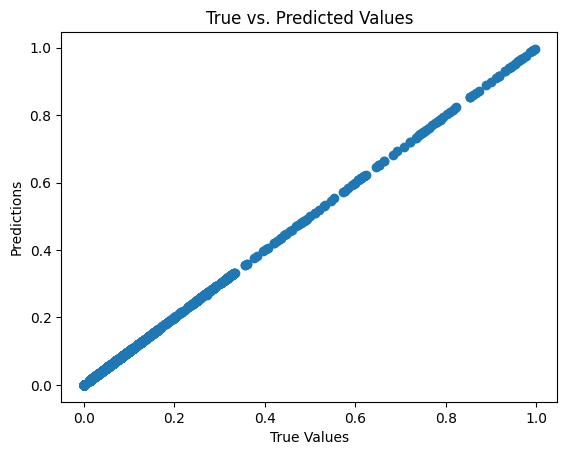

In [18]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

In [19]:
import math
def rounded_up_to_nearest(vale, base = 100000):
  return math.ceil(vale / base) * base

def format_currency(value):
  return f'Rp{value:,.0f}'.replace(',', '.')

In [20]:
# Contoh data baru
new_data = {
    'goal_amount': 12000000,  # goal_amount
    'goal_duration': 4,  # goal_duration
    'current_savings': 2000000  # current_savings
}

# Siapkan array dengan semua fitur
new_data_array = np.array([
    new_data['goal_amount'],
    new_data['goal_duration'],
    new_data['current_savings']
]).reshape(1, -1)

# Normalisasi data
new_data_normalized = scaler_X.transform(new_data_array)

# Prediksi
predicted_normalized = model.predict(new_data_normalized)
predicted_original = scaler_y.inverse_transform(predicted_normalized)
predicted_roundedup = rounded_up_to_nearest(predicted_original[0][0])
predicted_formatted = format_currency(predicted_roundedup)

print("Dengan melihat tujuan keuangan anda, kami merekomendasikan anda untuk menyisihkan\nsebesar", predicted_formatted, "setiap bulannya.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Dengan melihat tujuan keuangan anda, kami merekomendasikan anda untuk menyisihkan
sebesar Rp2.600.000 setiap bulannya.


In [21]:
model.save("financial_goal_model.h5")